In [30]:
import numpy as np
import h5py
import matplotlib
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import os


# Load .npy file using numpy
input_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_noTDS_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
output_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test/z1_4_33-x01.04-y00.82_TDS64iso_df0nm_conv30mrad_samp0p1A_step0p2A_thickness24uc.hdf5"
label_dir = "/media/muller_group/dm852_ExPro/ZSense/shared_hackathon/test_Z_map/z1_4_33-x01.04-y00.82.npy"

tempNoT = h5py.File(input_dir, 'r')
input_data = tempNoT['array'][:]  # Shape (batch_size, channels, height, width)

tempTDS = h5py.File(input_dir, 'r')
output_data = tempTDS['array'][:]  # Shape (batch_size, channels, height, width)

label_data = np.load(label_dir)  # Shape (batch_size, label_dim)

# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)
label_tensor = torch.tensor(label_data, dtype=torch.float32)

# Check shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Output tensor shape: {output_tensor.shape}")
print(f"Label tensor shape: {label_tensor.shape}")


Input tensor shape: torch.Size([59, 59, 64, 64])
Output tensor shape: torch.Size([59, 59, 64, 64])
Label tensor shape: torch.Size([59, 59])


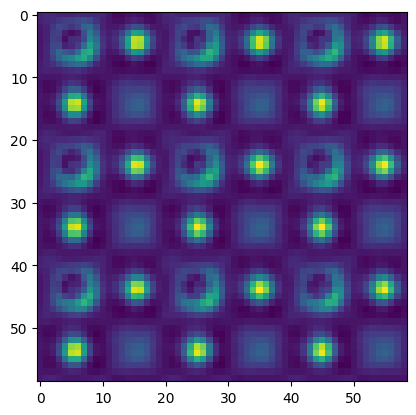

In [31]:
plt.imshow(input_tensor[:,:,32,32])

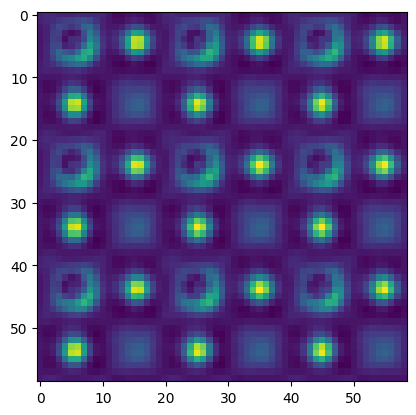

In [33]:
plt.imshow(output_tensor[:,:,32,32])

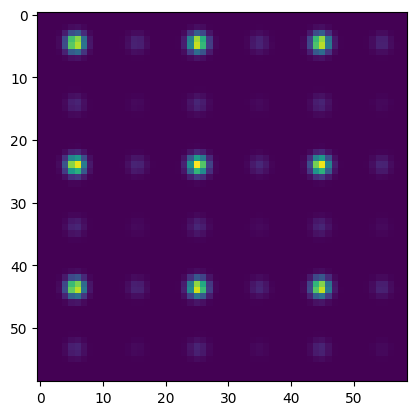

In [32]:
plt.imshow(label_tensor)

In [37]:
class IntoInelastic2D(nn.Module):
    def __init__(self):
        super(IntoInelastic2D, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(2, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.dec3 = self.upconv_block(512 + 256, 256)
        self.dec2 = self.upconv_block(256 + 128, 128)
        self.dec1 = self.upconv_block(128 + 64, 64)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """A convolutional block with two Conv2D layers and ReLU activations."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        """An upsampling block with transposed convolution and a conv block."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc3, 2))

        # Decoder
        dec3 = self.dec3(torch.cat((self.upsample(bottleneck, enc3), enc3), dim=1))
        dec2 = self.dec2(torch.cat((self.upsample(dec3, enc2), enc2), dim=1))
        dec1 = self.dec1(torch.cat((self.upsample(dec2, enc1), enc1), dim=1))

        # Final output
        final_output = self.final(dec1)

        # Ensure output size matches target (64x64)
        final_output = F.interpolate(final_output, size=(64, 64), mode='bilinear', align_corners=False)
        return final_output


    def upsample(self, x, target):
        """Upsample `x` to the size of `target`."""
        return F.interpolate(x, size=target.shape[2:], mode='bilinear', align_corners=True)

In [38]:
import torch
from torch.utils.data import DataLoader, Dataset

# Example Dataset Class
class CustomDataset(Dataset):
    def __init__(self, input_data, label_data, output_data):
        self.input_data = input_data
        self.label_data = label_data
        self.output_data = output_data

    def __len__(self):
        return self.input_data.shape[0] * self.input_data.shape[1]

    def __getitem__(self, idx):
        # Find correct index in 2D structure
        i = idx // self.input_data.shape[1]
        j = idx % self.input_data.shape[1]

        # Extract 64x64 image, label, and target
        image = self.input_data[i, j]      # Shape (64, 64)
        label = self.label_data[i, j]     # Shape ()
        target = self.output_data[i, j]   # Shape (64, 64)

        # Combine image and label into 2-channel input
        combined_input = torch.stack([image, torch.full_like(image, label)], dim=0)
        return combined_input, target

# # Load Data
# input_data = torch.randn(59, 59, 64, 64)  # Replace with actual data
# label_data = torch.randn(59, 59)         # Replace with actual labels
# output_data = torch.randn(59, 59, 64, 64)  # Replace with target output

# Create Dataset and DataLoader
dataset = CustomDataset(input_data, label_data, output_data)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize Model, Loss, Optimizer
model = IntoInelastic2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(5):
    model.train()
    for combined_input, target in dataloader:
        optimizer.zero_grad()

        # Forward pass
        prediction = model(combined_input)

        # Reshape target to match prediction shape
        target = target.unsqueeze(1)  # Ensure target is (batch_size, 1, 64, 64)

        # Print shapes for debugging
        print(f"Prediction shape: {prediction.shape}, Target shape: {target.shape}")

        # Calculate and backpropagate loss
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")


Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0082
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0135
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 0.9868
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0062
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0002
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0048
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0024
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 1.0072
Prediction shape: torch.Size([8, 1, 64, 64]), Target shape: torch.Size([8, 1, 64, 64])
Epoch [1], Loss: 0.9975
P